# Fixed Wing Electric sUAS Sizing 
By Matthew Capece

Based on Lecture Notes of Dr. Mark Maughmer

### Setup

##### Imports

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

##### Constants

In [263]:
# Physical Constants
gravity = 9.80665               # m/s^2
gear_rolling_friction = .15     # rolling friction coefficient for landing gear on pavement 

# Standard Sea Level Atmosphere
density = 1.225                 # kg/m^3
temp_C = 15                     # C
temp_K = 288.2                  # K
pressure = 101325               # Pa
speed_of_sound = 340.3          # m/s
dynamic_viscosity = 1.789e-5    # kg/m/s
kinematic_viscosity = 1.460e-5  # m^2/s
gas_constant = 287.1            # J/kg/K
temp_lapse_rate = 0.0065        # K/m
molar_mass = 0.0289652          # kg/mol
ratio_of_specific_heats = 1.4   # unitless

### Mission Requirements

In [264]:
# Performance Requirements
range = 29              # km
endurance = 30          # min
m_payload = 2.7         # kg, payload mass (not required to fly)
v_stall = 12            # m/s, stall speed
v_cruise = 18           # m/s, cruise speed
v_touchdown = 14        # m/s, landing touchdown speed 
dist_to_roll = 20       # m
dist_land_roll = 40     # m
time_land_roll = 5      # s                                                           I DONT KNOW IF THIS IS CORRECT???
radius_turn = 30        # m
angle_climb_min = 20    # deg
angle_descent_min = 20  # deg

# Size Requirements
m_to_max = 25           # kg, takeoff (total) mass
span_max = 2.5          # m

# Calculations
dynamic_pressure_cruise = 1/2 * density * v_cruise**2
dynamic_pressure_stall = 1/2 * density * v_stall**2
dynamic_pressure_touchdown = 1/2 * density * v_touchdown**2
bank_angle_max_rad = np.arctan(v_cruise**2/ (gravity * radius_turn))  # Max bank angle required for a sustained level turn with specified truning radius
bank_angle_max_deg = bank_angle_max_rad * 180 / np.pi
bank_load_factor_max = 1 / np.cos(bank_angle_max_rad)                 # Lift load factor at max bank angle 
touchdown_speed_ratio = v_touchdown / v_stall                         # Ratio of touchdown speed over stall speed (j)

### Initial Estimates

##### Initial Size Estimates

In [265]:
# Based on experience and knowledge of similar aircraft
chord_inital = .3  # m
span_initial = 2   # m
m_to_initial = 7   # kg
e0_inital = .75    # Oswald Efficiency
e_initial = .9     # Span Efficiency
Cdo_initial = .02  # Parasite drag coefficient

w_to_initial = gravity * m_to_initial 
wing_area_initial = chord_inital * span_initial  # Estimates wing area as a rectangular wing
AR_initial = span_initial**2 / wing_area_initial
k_initial = 1 / (e0_inital * np.pi * AR_initial)


##### Initial Reynold's # Estimation

In [266]:
Re_cruise_inital = (density * v_cruise * chord_inital) / dynamic_viscosity
Re_stall_inial = (density * v_stall * chord_inital) / dynamic_viscosity

##### Initial Airfoil Selection

In [267]:
# Airfoil: psu94097-il
Cl_max = 1.2
Cl_max_flaps = 1.6

##### Initial Drag Estimates

In [268]:
Cd_land_inital = Cdo_initial + Cl_max**2 / (np.pi * e0_inital * AR_initial)       # Estimated Drag Coefficient during landing
D_land_initial = dynamic_pressure_touchdown * wing_area_initial * Cd_land_inital  # N, Estimated Drag during landing

### Constraint Diagrams

C:\Users\mbcap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


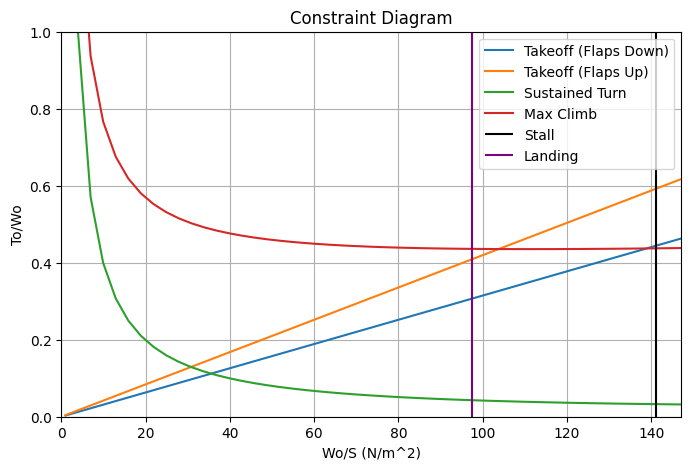

In [269]:
# Data Range
wing_loading_max = 150  # g/dm^2, Wing loading using mass (NOT WEIGHT)
wing_loading_weight_max = wing_loading_max / 10 * gravity  # N/m^2, Wing Loading in terms of weight (NOT MASS) 
wing_loading_array = np.linspace(1, wing_loading_weight_max)  #N/m^2, Plotted Wing Loading Range

# Takeoff Calculation
thrust_to_weight_to_flaps_array = wing_loading_array * [1.21 / (gravity * density * Cl_max_flaps * dist_to_roll)]  # Takeoff Curve WITH FLAPS
thrust_to_weight_to_array = wing_loading_array * [1.21 / (gravity * density * Cl_max * dist_to_roll)]  # Takeoff Curve WITHOUT FLAPS

# Landing Calculation
def landing_ground_roll(wing_loading):
    x = touchdown_speed_ratio * time_land_roll * (2/density * wing_loading / Cl_max_flaps)**.5 \
    - touchdown_speed_ratio**2 * wing_loading / (gravity * density * Cl_max_flaps * (D_land_initial / w_to_initial + gear_rolling_friction *(1-.2))) - dist_land_roll   # Assumed L\W = .2
    return x
wing_loading_landing = fsolve(landing_ground_roll,20)  # Solves for wing_loading_landing

# def landing_ground_roll(wing_loading):
#     x = touchdown_speed_ratio * time_land_roll * (2/density * wing_loading / Cl_max_flaps)**.5 \
#     - (.5 * time_land_roll**2 * gravity * (D_land_initial / w_to_initial + gear_rolling_friction *(1-.2))) - dist_land_roll   # Assumed L\W = .2
#     return x
# wing_loading_landing = fsolve(landing_ground_roll,20)  # Solves for wing_loading_landing

# def landing_ground_roll(wing_loading):
#     x = touchdown_speed_ratio**2 * (2/density * wing_loading / Cl_max_flaps) / (2 * gravity * (D_land_initial / w_to_initial + gear_rolling_friction *(1-.2))) - dist_land_roll   # Assumed L\W = .2
#     return x
# wing_loading_landing = fsolve(landing_ground_roll,20)  # Solves for wing_loading_landing

# Climb
climb_gradient_min = np.tan(angle_climb_min * np.pi / 180)  # Ratio of vertical speed over horizontal speed (angle in deg)
thrust_to_weight_climb_array = wing_loading_array * (k_initial / dynamic_pressure_cruise) + (dynamic_pressure_cruise * Cdo_initial) / wing_loading_array  +  climb_gradient_min

# Stall Speed Wingloading
wing_loading_stall_inital = dynamic_pressure_stall * Cl_max_flaps   # Wingloading at stall WITH FLAPS

# Sustained Turn Calculation
thrust_to_weight_bank_array = ((bank_load_factor_max * k_initial * wing_loading_array) / dynamic_pressure_cruise)**2 + dynamic_pressure_cruise * Cdo_initial / wing_loading_array  


# Plot Constraints
fig, ax = plt.subplots(figsize=(8,5))
xlim = wing_loading_array[-1]
ylim = 1
ax.plot(wing_loading_array, thrust_to_weight_to_flaps_array, label='Takeoff (Flaps Down)')
ax.plot(wing_loading_array, thrust_to_weight_to_array, label='Takeoff (Flaps Up)')
ax.plot(wing_loading_array, thrust_to_weight_bank_array, label='Sustained Turn')
ax.plot(wing_loading_array, thrust_to_weight_climb_array, label='Max Climb')
ax.vlines(wing_loading_stall_inital, 0, ylim, label = 'Stall', colors='black')
ax.vlines(wing_loading_landing[0], 0, ylim, label = 'Landing', colors='purple')
ax.set_xlim([0,xlim])
ax.set_ylim([0,ylim])
ax.set_title('Constraint Diagram')
ax.set_xlabel('Wo/S (N/m^2)')
ax.set_ylabel('To/Wo')
ax.grid()
ax.legend(loc='upper right')

### Stall Speed???

### Initial Shape Estimates

In [270]:
# Airfoil Selection
# Wing Geometry
# Tail Geometry
# Power Plants
# High Lift Devices

### Battery Weight Estimate

In [271]:
# Use Breguet Range Equation

### L/D Estimate

### Takeoff Weight Estimate

### Preliminary Wing Design

In [272]:
# Wing Area
# Wing Loading
# Plots
# Choose Aspect Ratio

### Tail Sizing

### Performance Calculations